WRITE-UPs for CNN OPEN LOCATION CODE CLASSIFICATION 

1) Datasets used: Simplified_Citation_After_2015July_to_2019.csv, CAMS_ZIPCODE_STREET_SPECIFIC.shp

2) Original columns dropped: 'Unnamed: 0', 'Ticket number', 'VIN', 'Make', 'Body Style', 'Color',
                         
                            'index_right', 'OBJECTID_1', 'OBJECTID', 'FID_1', 'Name',

                            'SDE_STATE_', 'ORIG_FID', 'Distance', 'geometry'

3) 'Issue Date' and 'Issue time' are dropped after processing and sorting

4) Open Location Code 'OLC' target variable with 74-classes is created based on Latitude and Longitude

5) OLC has huge class imbalance; however, imbalance problem left untackled to preserve location-specific granularity classification

6) zip_df is the finalized after-processed dataframe

7) Same model architecture as previous CNN Zipcode classification excpet for certain changes:
    
    a) number of epochs = 60
    
    b) EarlyStopping = 5
    
    c) Learning Rate Reducing Factor = 0.92
    
    d) Adding ModelCheckpoint to save best model for reuse

8) As expected due to so many classes and imbalance issue, the result for first iteration is not impressive; nevertheless, the model is gradually improving (in terms of loss reduction and increasing acc for both train and validation sets)

9) 1st iteration: val_accuracy= 0.5677

10) Best iteration: val_accuracy= 0.87060

11) Val_acc graph shows constant upward trend; Val_loss graph shows constant downward trend

12) Since both graphs have no huge ups/downs, the model seems to keep learning

13) 87% validation acc sounds solid for imbalanced 74-classes, but maybe next time we could improve to over 90%

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_auc_score
from catboost import CatBoostClassifier,Pool, cv
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

from openlocationcode.openlocationcode import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import time
sns.set()
%matplotlib inline
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pyproj

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D,MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import callbacks

In [5]:
#1
df = pd.read_csv('../input/laparking-simplified/Simplified_Citation_After_2015July_to_2019.csv')
print(df.shape)

(87554, 19)


In [6]:
#2
zipcode = geopandas.read_file('../input/cams-zipcode-street-specific/CAMS_ZIPCODE_STREET_SPECIFIC.shp')
print(zipcode.shape)

(358, 11)


In [7]:
#3
geometry = [Point(xy) for xy in zip(df["Latitude"],df["Longitude"])] 
geometry[:3]

In [8]:
#4
df = geopandas.GeoDataFrame(df, geometry= geometry)
df.head()

,Unnamed: 0,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,geometry
0,28,4361326712,2019/09/17 12:00:00 AM,1205.0,NaN,NaN,CA,NaN,TOYT,PA,GY,309 WINDWARD AVE,00163,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.419487e+06,1.818861e+06,POINT (6419487.346 1818860.518)
1,112,4361286823,2019/09/17 12:00:00 AM,853.0,NaN,NaN,CA,NaN,TOYT,PA,WT,934 84TH ST W,00553,55.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.473690e+06,1.808839e+06,POINT (6473689.884 1808838.586)
2,224,4361159515,2019/09/17 12:00:00 AM,833.0,NaN,NaN,CA,NaN,NISS,PA,WT,2601 MONMOUTH AVE,00536,55.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.475329e+06,1.834194e+06,POINT (6475329.075 1834193.637)
3,473,4361237226,2019/09/17 12:00:00 AM,1015.0,NaN,NaN,CA,NaN,HOND,PA,RD,615 HAMPTON DR,00133,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.417752e+06,1.820642e+06,POINT (6417752.445 1820641.850)
4,592,4360129196,2019/09/17 12:00:00 AM,1007.0,NaN,NaN,CA,NaN,VOLV,PA,SL,1346 MCCADDEN PL N,00487,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.459495e+06,1.857205e+06,POINT (6459494.955 1857204.982)


In [9]:
#5
zip_df = geopandas.sjoin(df, zipcode, how="inner", op='intersects')
print(zip_df.shape)

(76138, 31)


In [10]:
#6
zip_df.head()

,Unnamed: 0,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,VIN,Make,Body Style,...,OBJECTID_1,OBJECTID,FID_1,Name,SDE_STATE_,ORIG_FID,Distance,Zip_Num,Shape_area,Shape_len
0,28,4361326712,2019/09/17 12:00:00 AM,1205.0,NaN,NaN,CA,NaN,TOYT,PA,...,60,117,59,90291,0.0,8598,0.0,90291,6.573165e+07,42418.357952
3,473,4361237226,2019/09/17 12:00:00 AM,1015.0,NaN,NaN,CA,NaN,HOND,PA,...,60,117,59,90291,0.0,8598,0.0,90291,6.573165e+07,42418.357952
77,7964,4360539886,2019/09/11 12:00:00 AM,817.0,NaN,NaN,CA,NaN,BUIC,PA,...,60,117,59,90291,0.0,8598,0.0,90291,6.573165e+07,42418.357952
135,14174,4361088071,2019/09/08 12:00:00 AM,201.0,NaN,NaN,CA,NaN,HOND,PA,...,60,117,59,90291,0.0,8598,0.0,90291,6.573165e+07,42418.357952
235,24013,4360163161,2019/08/30 12:00:00 AM,1810.0,VL108,NaN,CA,NaN,TOYT,PU,...,60,117,59,90291,0.0,8598,0.0,90291,6.573165e+07,42418.357952


In [11]:
#7
zip_df.columns

Index(['Unnamed: 0', 'Ticket number', 'Issue Date', 'Issue time', 'Meter Id',
       'Marked Time', 'RP State Plate', 'VIN', 'Make', 'Body Style', 'Color',
       'Location', 'Route', 'Agency', 'Violation code',
       'Violation Description', 'Fine amount', 'Latitude', 'Longitude',
       'geometry', 'index_right', 'OBJECTID_1', 'OBJECTID', 'FID_1', 'Name',
       'SDE_STATE_', 'ORIG_FID', 'Distance', 'Zip_Num', 'Shape_area',
       'Shape_len'],
      dtype='object')

In [12]:
#8
zip_df.drop(['Unnamed: 0', 'Ticket number', 'VIN', 'Make', 'Body Style', 'Color',
'index_right', 'OBJECTID_1', 'OBJECTID', 'FID_1', 'Name',
'SDE_STATE_', 'ORIG_FID', 'Distance'], axis=1, inplace=True)
print(zip_df.shape)

(76138, 17)


In [13]:
#9
zip_df.columns

Index(['Issue Date', 'Issue time', 'Meter Id', 'Marked Time', 'RP State Plate',
       'Location', 'Route', 'Agency', 'Violation code',
       'Violation Description', 'Fine amount', 'Latitude', 'Longitude',
       'geometry', 'Zip_Num', 'Shape_area', 'Shape_len'],
      dtype='object')

In [14]:
#10
zip_df.isnull().sum()

Issue Date                   0
Issue time                  11
Meter Id                 54920
Marked Time              73582
RP State Plate               1
Location                     0
Route                      331
Agency                       0
Violation code               0
Violation Description        2
Fine amount                 23
Latitude                     0
Longitude                    0
geometry                     0
Zip_Num                      0
Shape_area                   0
Shape_len                    0
dtype: int64

In [15]:
#11
zip_df['Zip_Num'].value_counts().sort_values(ascending=False)

90028    3689
90015    2757
90025    2704
90036    2599
90291    2548
         ... 
91803       1
90212       1
90095       1
91201       1
91505       1
Name: Zip_Num, Length: 126, dtype: int64

In [16]:
#12
# Conversion using pyproj module
inProj = pyproj.Proj('epsg:2229', preserve_units=True) # make sure unit preserve 
outProj = pyproj.Proj('epsg:4326')
y_1,x_1 = pyproj.transform(inProj,outProj,zip_df["Latitude"].values,zip_df["Longitude"].values)
zip_df["Latitude"] = y_1
zip_df["Longitude"] = x_1

In [28]:
#13
zip_df['OLC'] = zip_df[["Latitude", "Longitude"]].apply(lambda l: encode(l[0], l[1], codeLength=6), axis = 1)

In [ ]:
# data processing......

In [67]:
X = zip_df.drop(labels=['OLC'], axis=1)
y = zip_df['OLC'].values

In [68]:
X_train = X[:53246]
X_cv = X[53246:]
y_train = y[:53246]
y_cv = y[53246:]

In [69]:
X_train = X_train.to_numpy()
X_cv = X_cv.to_numpy()

In [70]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_cv = X_cv.reshape(X_cv.shape[0],X_cv.shape[1],1)

In [71]:
# Convolutional Neural Networks (CNN)
epoch = 60
model = Sequential()
model.add(Conv1D(40,2,activation='elu',kernel_initializer='he_normal',input_shape = X_train[0].shape))
model.add(BatchNormalization())

model.add(Conv1D(70,2,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(100,2,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(100,2,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64,activation='elu', kernel_initializer='he_normal'))

model.add(Dense(74,activation='softmax'))

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 233, 40)           120       
_________________________________________________________________
batch_normalization (BatchNo (None, 233, 40)           160       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 232, 70)           5670      
_________________________________________________________________
batch_normalization_1 (Batch (None, 232, 70)           280       
_________________________________________________________________
dropout (Dropout)            (None, 232, 70)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 231, 100)          14100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 231, 100)          4

In [73]:
model.compile(optimizer=Adam(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [74]:
earlystop = EarlyStopping(patience=5) 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.92, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', verbose=1, 
                save_best_only=True, mode='max', period=1)
callbacks = [earlystop, learning_rate_reduction, checkpointer
            ]

In [75]:
history = model.fit(X_train, y_train, epochs=epoch, 
                    validation_data=(X_cv, y_cv), 
                    callbacks=callbacks,verbose=1)

Train on 53246 samples, validate on 22820 samples
Epoch 1/60
53216/53246 [============================>.] - ETA: 0s - loss: 1.9045 - accuracy: 0.4295
Epoch 00001: val_accuracy improved from -inf to 0.56766, saving model to model.h5
53246/53246 [==============================] - 119s 2ms/sample - loss: 1.9041 - accuracy: 0.4296 - val_loss: 1.2720 - val_accuracy: 0.5677
Epoch 2/60
53216/53246 [============================>.] - ETA: 0s - loss: 1.1844 - accuracy: 0.6053
Epoch 00002: val_accuracy improved from 0.56766 to 0.66012, saving model to model.h5
53246/53246 [==============================] - 118s 2ms/sample - loss: 1.1844 - accuracy: 0.6053 - val_loss: 1.0012 - val_accuracy: 0.6601
Epoch 3/60
53216/53246 [============================>.] - ETA: 0s - loss: 0.9976 - accuracy: 0.6587
Epoch 00003: val_accuracy improved from 0.66012 to 0.69049, saving model to model.h5
53246/53246 [==============================] - 117s 2ms/sample - loss: 0.9976 - accuracy: 0.6588 - val_loss: 0.8905 - va

In [76]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

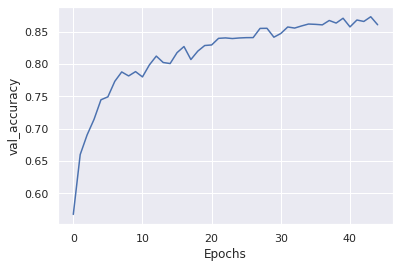

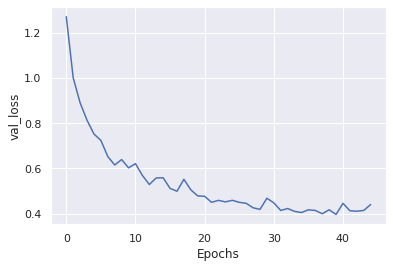

In [77]:
plot_graphs(history, 'val_accuracy')
plot_graphs(history, 'val_loss')